<a href="https://colab.research.google.com/github/statrav/pages/blob/main/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 필요한 PyTorch Libarary import

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

import PIL
import matplotlib.pyplot as plt

import copy

In [2]:
# GPU 장치 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 이미지를 불러오고 다운받아서, Tensor 객체로 변환하는 함수
def image_loader(img_path, imsize):
  loader = transforms.Compose([
      transforms.Resize(imsize), # 이미지의 크기를 imsize로 변경
      transforms.ToTensor() # 이미지를 torch.Tensor 형식으로 변경 [0, 255] → [0, 1]
  ])
  image = PIL.Image.open(img_path) # 이미지 가져오기 (PIL : Python Image Library)
  image = loader(image).unsqueeze(0) # 가져온 이미지에 Batch 목적의 차원(dimension)을 추가
  return image.to(device, torch.float) # GPU로 올리기

In [4]:
# torch.Tensor 형태의 이미지를 출력하는 함수
def imshow(tensor):
  image = tensor.cpu().clone() # matplotlib은 CPU 기반이므로, CPU로 옮김
  image = image.squeeze(0) # torch.Tensor에서 사용되는 Batch 목적의 차원(dimension) 제거 (↔ unsqueeze)
  image = transforms.ToPILImage()(image) # PIL객체로 변경
  plt.imshow(image) # 이미지 출력
  plt.show()

In [5]:
# git에서 소스코드 다운로드하여 실습용 이미지 가져오기
!git clone https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice
%cd Deep-Learning-Paper-Review-and-Practice

Cloning into 'Deep-Learning-Paper-Review-and-Practice'...
remote: Enumerating objects: 462, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 462 (delta 72), reused 190 (delta 65), pack-reused 261
Receiving objects: 100% (462/462), 53.82 MiB | 40.70 MiB/s, done.
Resolving deltas: 100% (152/152), done.
/content/Deep-Learning-Paper-Review-and-Practice


In [6]:
## Style Transfer

[ Content Image ]


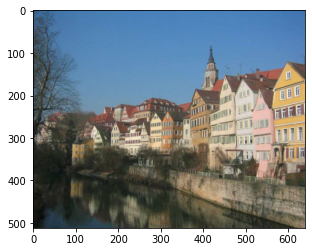

[ Style Image ]


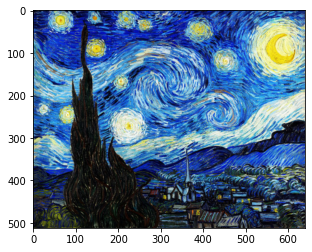

In [7]:
content_img = image_loader('./code_practices/images/content_img_1.jpg', (512, 640))
style_img = image_loader('./code_practices/images/style_img_1.jpg', (512, 640))

print("[ Content Image ]")
imshow(content_img)
print("[ Style Image ]")
imshow(style_img)

In [8]:
# Feature Extractor(특징 추출기)로 VGG Network 선택

cnn = models.vgg19(pretrained = True).features.to(device).eval() 
# 사전 학습된 19 layer의 vgg 모델 
  # eval() : evaluation(평가) mode → 실제 Image를 Test 목적으로 넣음
  # features : 각 layer에 대한 output feature 값을 도출해냄 
    # Image 분류 목적으로 Network를 사용하는 것이 아니라, feature를 추출하기 위한 목적이므로 feature에만 접근하도록 Model을 초기화한 것
  # to(device) : GPU
print(cnn)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [9]:
# 입력 정규화(Normalization)을 위한 초기화
  # vgg network는 학습 시점에 '입력으로 들어오는 Image를 정규화(Normalization)한 뒤에 결과를 구하는 형태'로 학습되어 있음
  # 학습할 때 사용되었던 정규화함수를 그대로 적용
  
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().view(-1, 1, 1)
        self.std = std.clone().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [10]:
## Style Reconstruction

In [11]:
def gram_matrix(input):
  a, b, c, d = input.size() # 기본적인 PyTorch에서의 Tensor 구성 - a : 배치크기 / b : feature map의 개수 / (c, d) : feature map의 dimension(차원)
  features = input.view(a * b, c * d) # 단순한 행렬 형태로 바꾸어주기 (i, j) - i : feature map의 개수 / j : 각 위치(position)에 대한 activation 값
  G = torch.mm(features, features.t()) # feature행렬과 전치 행렬의 곱을 통해 Gram 내적 계산 → 서로 다른 2개의 feature의 상관관계가 얼마나 높은지 반환 
  return G.div(a * b * c * d)  # 값이 너무 커지는 것을 방지하가 위해 (a * b * c * d) 값으로 나누어 Normalization 수행

In [12]:
class StyleLoss(nn.Module):
  def __init__(self, target_feature): 
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_feature).detach() # 하나의 target_feature에 대해 gram_matrix를 구함
  
  def forward(self, input):
    G = gram_matrix(input) # 입력 값으로 들어온 feature에 대해 gram_matrix를 구함
    self.loss = F.mse_loss(G, self.target) # 2개의 gram_matrix에 대한 차이 값을 구하여 loss 계산
    return input

In [13]:
# style_layer 임의로 지정
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [14]:
def get_style_losses(cnn, style_img, noise_image):
  cnn = copy.deepcopy(cnn)
  normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device) 
  style_losses = []

  model = nn.Sequential(normalization) # 입력 이미지를 Network에 넣기 전에, 입력 정규화(input normalization)을 수행하도록 함

  # 특정 layer까지의 결과를 사용할 수 있도록 하기 위해, layer를 하나씩 확인하며 다시 model에 붙여나가는 방식으로 특정 layer까지의 결과를 얻는 작업
  i = 0
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = 'conv_{}'.format(i) # convolutional layer
    elif isinstance(layer, nn.ReLU):
      name = 'relu_{}'.format(i) # relu layer
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool_{}'.format(i) # pooling layer
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_{}'.format(i) # batch normalization layer
    else:
      raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    model.add_module(name, layer)

    if name in style_layers:
      target_feature = model(style_img).detach() # 임의로 설정한 style_layer 각각에 대해서 그 layer까지의 결과를 얻을 수 있음
      style_loss = StyleLoss(target_feature) # StyleLoss 객체를 초기화한 뒤 style_loss를 얻음
      model.add_module("style_loss_{}".format(i), style_loss)
      style_losses.append(style_loss)

  for i in range(len(model) - 1, -1, -1): # i 변수에 마지막 layer에 대한 위치 값 기록 → 마지막 style loss 이후의 layer는 사용하지 않기 위함
        if isinstance(model[i], StyleLoss):
            break

  model = model[:(i + 1)]
  return model, style_losses

In [15]:
def style_reconstruction(cnn, style_img, input_img, iters):
  model, style_losses = get_style_losses(cnn, style_img, input_img) # 압축된 model과 stlye_loss 정보 구함
  optimizer = optim.LBFGS([input_img.requires_grad_()]) # LBFGS optimizer 선택

  print("[ Start ]")
  imshow(input_img)

  run = [0] # 하나의 값만 이용하기 위해서 배열 형태로 사용
  while run[0] <= iters: # 반복 횟수만큼 업데이트
    
    def closure():
      input_img.data.clamp_(0, 1) # input image가 (0, 1) 이미지 범위를 벗어나지 않게 구간 잘라줌

      optimizer.zero_grad() # optimizer의 gradient 값 초기화
      model(input_img) # model에 input값 투입 
      style_score = 0

      for sl in style_losses:
        style_score += sl.loss # style_loss 값 구함

      style_score *= 1e6 # style_loss가 매우 작은 상황을 대비하여, 특정 가중치를 곱해줌
      style_score.backward() # back propogation을 통해 gradient 구하기

      run[0] += 1
      if run[0] % 50 == 0 :
        print(f'[ Step : {run[0]} / Style loss : {style_score.item()} ]')
        imshow(input_img)
        
      return style_score

    optimizer.step(closure) # gradient 업데이트

  input_img.data.clamp_(0, 1) # 이미지의 각 픽셀의 값이 (0, 1) 사이의 값이 되도록 자름

  return input_img
      

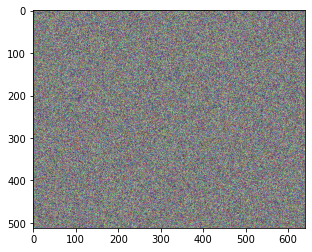

In [16]:
# content_image와 동일한 크기의 noise_image 만들기
input_img = torch.empty_like(content_img).uniform_(0, 1).to(device)
imshow(input_img)

[ Start ]


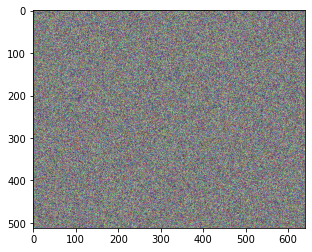

[ Step : 50 / Style loss : 425.09515380859375 ]


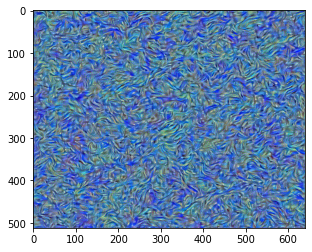

[ Step : 100 / Style loss : 109.91584014892578 ]


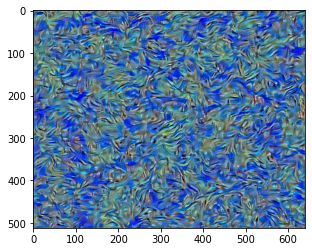

[ Step : 150 / Style loss : 50.21654510498047 ]


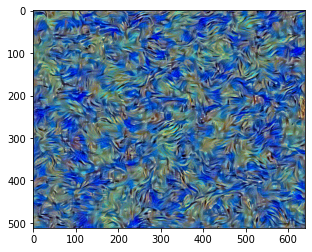

[ Step : 200 / Style loss : 35.51114273071289 ]


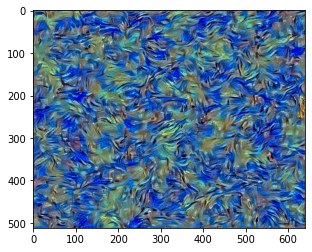

[ Step : 250 / Style loss : 28.566667556762695 ]


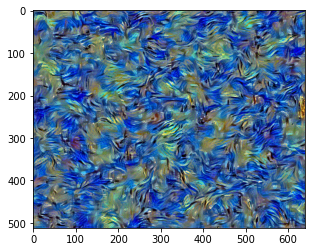

[ Step : 300 / Style loss : 23.50739288330078 ]


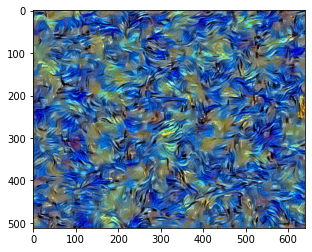

In [17]:
output = style_reconstruction(cnn, style_img = style_img, input_img = input_img, iters = 300)

In [18]:
## Content Reconstruction (Style Reconstruction과 방법 동일)

In [19]:
class ContentLoss(nn.Module):
  def __init__(self, target, ):
    super(ContentLoss, self).__init__()
    self.target = target.detach()

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input

In [23]:
content_layers = ['conv_4']

# 콘텐츠 손실(content loss)을 계산하는 함수
def get_content_losses(cnn, content_img, noise_image):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
    content_losses = []
    
    # 가장 먼저 입력 이미지가 입력 정규화(input normalization)를 수행하도록
    model = nn.Sequential(normalization)

    # 현재 CNN 모델에 포함되어 있는 모든 레이어를 확인하며
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        # 설정한 content layer까지의 결과를 이용해 content loss를 계산
        if name in content_layers:
            target_feature = model(content_img).detach()
            content_loss = ContentLoss(target_feature)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

    # 마지막 content loss 이후의 레이어는 사용하지 않도록
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss):
            break

    model = model[:(i + 1)]
    return model, content_losses

In [24]:
def content_reconstruction(cnn, content_img, input_img, iters):
    model, content_losses = get_content_losses(cnn, content_img, input_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print("[ Start ]")
    imshow(input_img)

    # 하나의 값만 이용하기 위해 배열 형태로 사용
    run = [0]
    while run[0] <= iters:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            content_score = 0

            for cl in content_losses:
                content_score += cl.loss

            content_score.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"[ Step: {run[0]} / Content loss: {content_score.item()}]")
                imshow(input_img)
            
            return content_score
        
        optimizer.step(closure)

    # 결과적으로 이미지의 각 픽셀의 값이 [0, 1] 사이의 값이 되도록 자르기
    input_img.data.clamp_(0, 1)

    return input_img

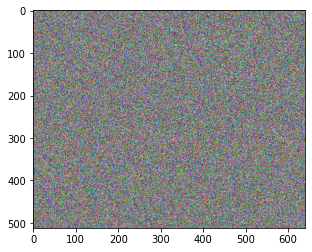

In [21]:
# 콘텐츠 이미지와 동일한 크기의 노이즈 이미지 생성
input_img = torch.empty_like(content_img).uniform_(0, 1).to(device)
imshow(input_img)

[ Start ]


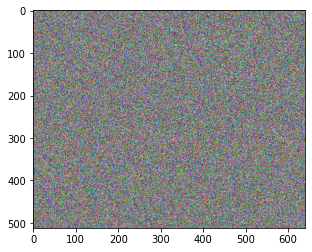

[ Step: 50 / Content loss: 0.7482184767723083]


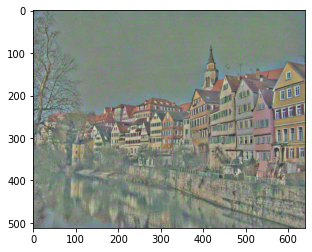

[ Step: 100 / Content loss: 0.37644538283348083]


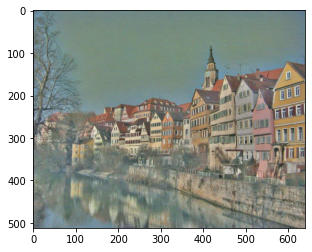

[ Step: 150 / Content loss: 0.24390792846679688]


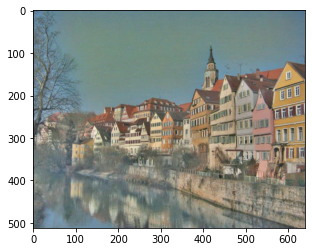

[ Step: 200 / Content loss: 0.17569051682949066]


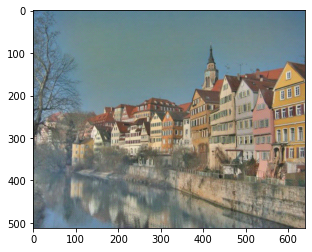

[ Step: 250 / Content loss: 0.13421368598937988]


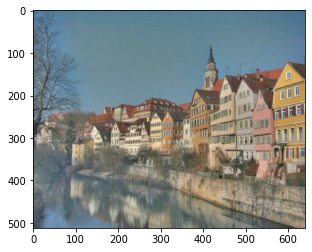

[ Step: 300 / Content loss: 0.1046915277838707]


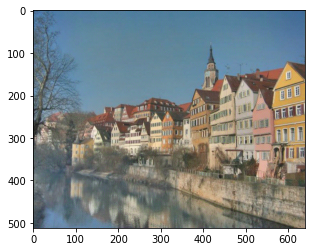

In [25]:
output = content_reconstruction(cnn, content_img=content_img, input_img=input_img, iters=300)

In [26]:
## Style Transfer

In [27]:
#임의의 layer선정
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_3', 'conv_5', 'conv_7', 'conv_9']

In [46]:
# Style Transfer 손실(loss)을 계산하는 함수
def get_losses(cnn, content_img, style_img, noise_image):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
    content_losses = []
    style_losses = []
    
    # 가장 먼저 입력 이미지가 입력 정규화(input normalization)를 수행하도록
    model = nn.Sequential(normalization)

    # 현재 CNN 모델에 포함되어 있는 모든 레이어를 확인하며
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        # 설정한 content layer까지의 결과를 이용해 content loss를 계산
        if name in content_layers:
            target_feature = model(content_img).detach()
            content_loss = ContentLoss(target_feature)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        # 설정한 style layer까지의 결과를 이용해 style loss를 계산
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # 마지막 loss 이후의 레이어는 사용하지 않도록
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    return model, content_losses, style_losses

In [47]:
def style_transfer(cnn, content_img, style_img, input_img, iters):
    model, content_losses, style_losses = get_losses(cnn, content_img, style_img, input_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print("[ Start ]")
    imshow(input_img)

    # 하나의 값만 이용하기 위해 배열 형태로 사용
    run = [0]
    while run[0] <= iters:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            content_score = 0
            style_score = 0

            for cl in content_losses:
                content_score += cl.loss
            for sl in style_losses:
                style_score += sl.loss

            style_score *= 1e5
            loss = content_score + style_score
            loss.backward()

            run[0] += 1
            if run[0] % 100 == 0:
                print(f"[ Step: {run[0]} / Content loss: {content_score.item()} / Style loss: {style_score.item()}]")
                imshow(input_img)
            
            return content_score + style_score
        
        optimizer.step(closure)

    # 결과적으로 이미지의 각 픽셀의 값이 [0, 1] 사이의 값이 되도록 자르기
    input_img.data.clamp_(0, 1)

    return input_img

[ Content Image ]


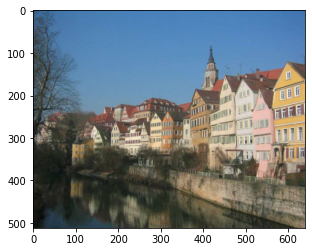

[ Style Image ]


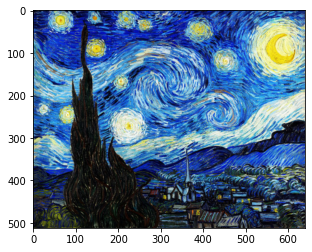

[ Input Image _noise ]


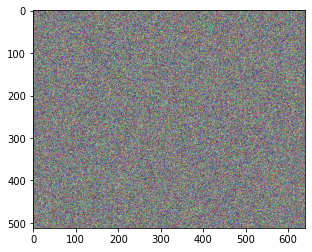

In [48]:
## Style Transfer 준비

content_img = image_loader('./code_practices/images/content_img_1.jpg', (512, 640))
style_img = image_loader('./code_practices/images/style_img_1.jpg', (512, 640))
input_img = torch.empty_like(content_img).uniform_(0, 1).to(device)

print("[ Content Image ]")
imshow(content_img)
print("[ Style Image ]")
imshow(style_img)
print("[ Input Image _noise ]")
imshow(input_img)

[ Start ]


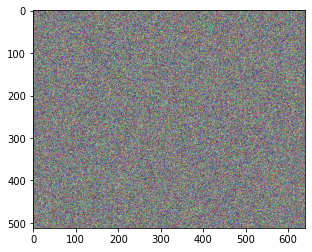

[ Step: 100 / Content loss: 44.73143768310547 / Style loss: 28.023357391357422]


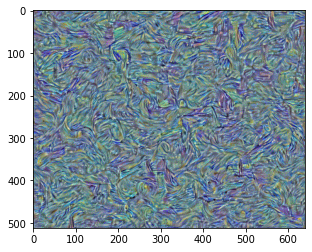

[ Step: 200 / Content loss: 37.00739288330078 / Style loss: 9.364035606384277]


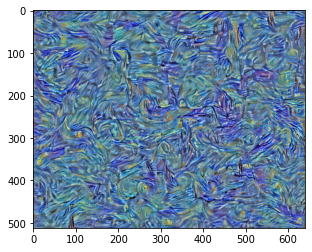

[ Step: 300 / Content loss: 31.444665908813477 / Style loss: 6.043833255767822]


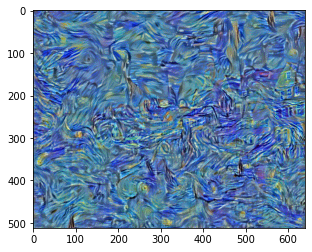

[ Step: 400 / Content loss: 27.860151290893555 / Style loss: 4.82167911529541]


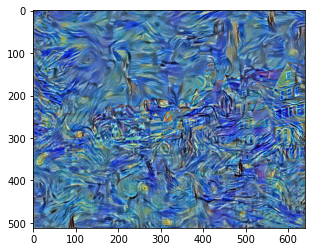

[ Step: 500 / Content loss: 25.435728073120117 / Style loss: 4.10999870300293]


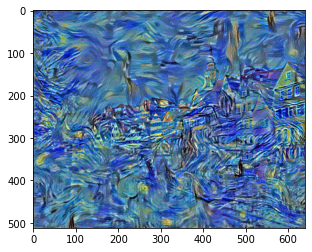

[ Step: 600 / Content loss: 23.71796226501465 / Style loss: 3.8098878860473633]


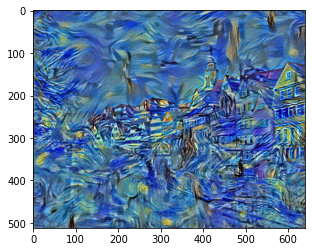

[ Step: 700 / Content loss: 22.61703872680664 / Style loss: 3.5535311698913574]


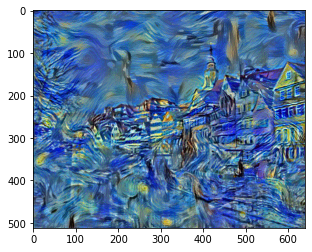

[ Step: 800 / Content loss: 21.8022518157959 / Style loss: 3.099517822265625]


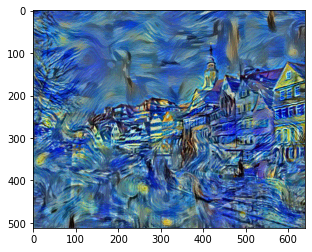

[ Step: 900 / Content loss: 20.996177673339844 / Style loss: 4.155313014984131]


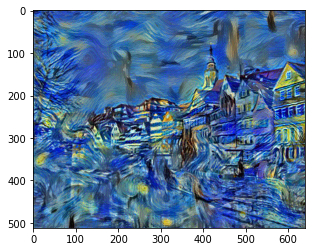

In [49]:
## Style Transfer 수행

output = style_transfer(cnn, content_img=content_img, style_img=style_img, input_img=input_img, iters=900)

In [50]:
from torchvision.utils import save_image

save_image(output.cpu().detach()[0], 'output_1.png')
print('이미지 파일 저장을 완료했습니다.')

이미지 파일 저장을 완료했습니다.


In [52]:
from google.colab import files

# 완성된 이미지 다운로드
files.download('output_1.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

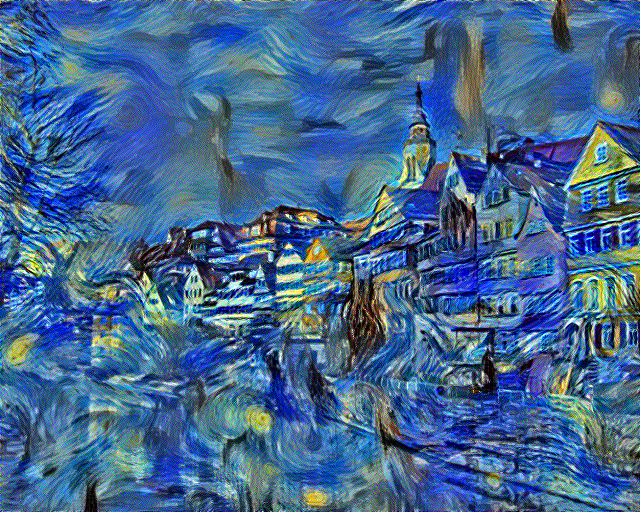

In [53]:
from IPython.display import Image

Image('output_1.png')